In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score

In [20]:

POI_FILENAME = "../data/poi-paris.pkl"
parismap = mpimg.imread('../data/paris-48.806-2.23--48.916-2.48.jpg')
# coordonnees GPS de la carte
xmin, xmax = 2.23, 2.48  # coord_x min et max
ymin, ymax = 48.806, 48.916  # coord_y min et max
coords = [xmin, xmax, ymin, ymax]

In [21]:
def get_density2D(f, data, steps=100):
    """ Calcule la densité en chaque case d'une grille steps x steps dont les bornes sont calculées à partir du min/max de data. Renvoie la grille estimée et la discrétisation sur chaque axe.
    """
    xmin, xmax = data[:, 0].min(), data[:, 0].max()
    ymin, ymax = data[:, 1].min(), data[:, 1].max()
    xlin, ylin = np.linspace(xmin, xmax, steps), np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(xlin, ylin)
    grid = np.c_[xx.ravel(), yy.ravel()]
    res = f.predict(grid).reshape(steps, steps)
    return res, xlin, ylin


def show_density(f, data, steps=100, log=False):
    """
    Dessine la densité f et ses courbes de niveau sur une grille 2D calculée à partir de data, avec un pas de discrétisation de steps. Le paramètre log permet d'afficher la log densité plutôt que la densité brute
    """
    res, xlin, ylin = get_density2D(f, data, steps)
    xx, yy = np.meshgrid(xlin, ylin)
    plt.figure()
    show_img()
    if log:
        res = np.log(res+1e-10)
    plt.scatter(data[:, 0], data[:, 1], alpha=0.8, s=3)
    show_img(res)
    plt.colorbar()
    plt.contour(xx, yy, res, 20)


def show_img(img=parismap):
    """ Affiche une matrice ou une image selon les coordonnées de la carte de Paris.
    """
    origin = "lower" if len(img.shape) == 2 else "upper"
    alpha = 0.3 if len(img.shape) == 2 else 1.
    plt.imshow(img, extent=coords, aspect=1.5, origin=origin, alpha=alpha)
    # extent pour controler l'echelle du plan


def load_poi(typepoi, fn=POI_FILENAME):
    """ Dictionaire POI, clé : type de POI, valeur : dictionnaire des POIs de ce type : (id_POI, [coordonnées, note, nom, type, prix])

    Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, 
    clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
    """
    poidata = pickle.load(open(fn, "rb"))
    data = np.array([[v[1][0][1], v[1][0][0]]
                    for v in sorted(poidata[typepoi].items())])
    note = np.array([v[1][1] for v in sorted(poidata[typepoi].items())])
    return data, note


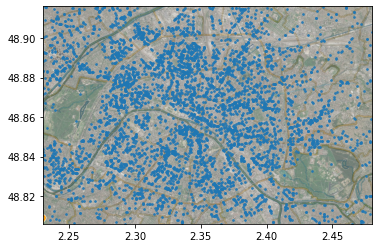

In [22]:
plt.ion()
# Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
# La fonction charge la localisation des POIs dans geo_mat et leur note.
geo_mat, notes = load_poi("bar")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:, 0], geo_mat[:, 1], alpha=0.8, s=3)

# Methode par Histogramme

In [47]:
class Density(BaseEstimator):
    def __init__(self) -> None:
        super().__init__()
    
    def fit(self, data):
        pass

    def predict(self, data):
        pass

    def score(self, data):
        density = self.predict(data)
        return np.log(np.where(density == 0, 1e-10, density)).sum()

In [48]:
class Histogramme(Density):
	def __init__(self, steps=10):
		Density.__init__(self)
		self.steps = steps
		self.density = None
		self.bins = None

	def fit(self, x):
		"""
		Apprend l'histogramme de la densité sur x
		"""
		self.density, self.bins = np.histogramdd(
			x, bins=[self.steps]*x.shape[-1], density=True
		)

	def predict(self, x):
		"""
		Retourne la densité associée à chaque point de x
		"""
		def to_bin(x):
			"""
			Assez tricky comme solution mais marche pour toute dimension
			Pour chaque dimension je regarde le bin associé. Pour comprendre rapidement la fonction, print les éléments
			"""
			oui = np.stack(self.bins, axis=1)
			l = []
			xi_dim = x.shape[-1]
			for xi in x:
				tmp = []
				for i in range(xi_dim):
					where = np.nonzero(oui[..., i] <= xi[..., i])[-1]
					if where.size == 0:
						tmp.append(None)
					else:
						tmp.append(where[-1] - 1)
				l.append(tuple(tmp))
			return l
		
		prediction = []
		for cords in to_bin(x):
			if cords == None:
				prediction.append(0)
			else:
				prediction.append(self.density[cords])
		return np.array(prediction)

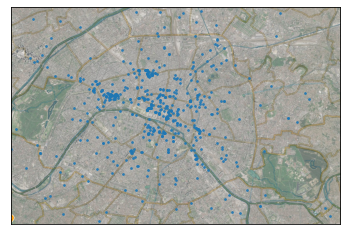

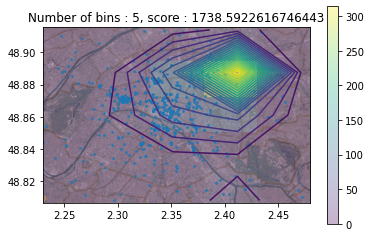

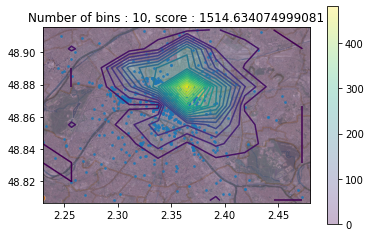

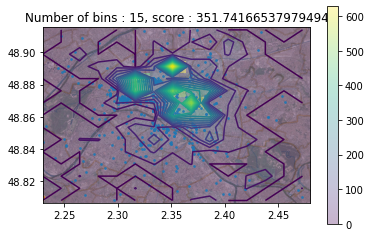

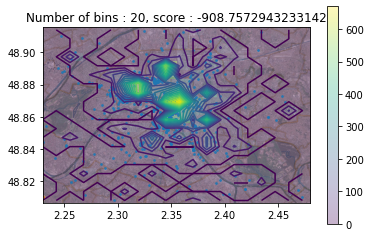

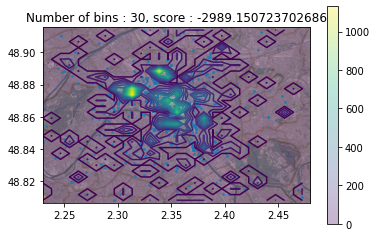

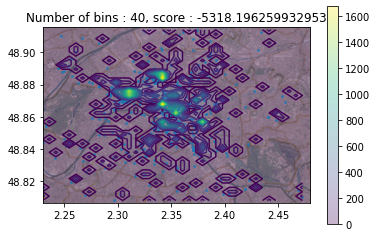

In [67]:
geo_mat, notes = load_poi("night_club")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
plt.xticks([])
plt.yticks([])

for steps in [5, 10, 15, 20, 30, 40]:
    nc_hist = Histogramme(steps)
    nc_hist.fit(geo_mat)
    nc_hist.predict(geo_mat)
    show_density(nc_hist, geo_mat, steps)
    plt.gca().set_title(f'Number of bins : {steps}, score : {nc_hist.score(geo_mat)}')

## Validation croisé

In [50]:
for steps in [5, 10, 15, 20, 30]:
    geo_mat, notes = load_poi("night_club")
    print(cross_val_score(Histogramme(steps=steps), geo_mat))
    break

[369.078506   365.31898465 369.73585975          nan 335.86028407]


/tmp/ipykernel_768/2375253944.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(prediction)
/tmp/ipykernel_768/3984486100.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return np.log(np.where(density == 0, 1e-10, density)).sum()
/home/charles/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
AttributeError: 'numpy.float64' object has no attribute 'log'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/charles/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py",

# Méthodes à noyaux

In [85]:
def kernel_uniform(x):
    bool_list = (np.abs(x) < 0.5).all(axis=1)
    return np.where(bool_list, 1, 0)

In [101]:
test_x = np.array(
    [[0.25, 0.2, 0.45],
    [0.25, 0.2, 0.55],
    [12991.70085, 271411.03284, 0.4],
    [12991.619831, 271411.321743, 0.4],
    [12991.763074, 271411.541286, 0.4]],
)
kernel_uniform(test_x)

array([1, 0, 0, 0, 0])

In [87]:
def kernel_gaussian(x):
    d = x.shape[-1]
    return np.exp(-0.5 * np.linalg.norm(x, axis=1)**2) * (2*np.pi)**(-d/2) 

In [102]:
kernel_gaussian(test_x)

array([0.05451303, 0.05185439, 0.        , 0.        , 0.        ])

In [114]:
class KernelDensity(Density):
    def __init__(self, kernel=None, sigma=0.1):
        Density.__init__(self)
        self.kernel = kernel
        self.sigma = sigma

    def fit(self, x):
        self.x = x

    def predict(self, data):
        # retourne la densité associée à chaque point de data
        n, d = self.x.shape
        l = []
        for x_i in data:
            x_i_stacked = np.vstack([x_i]*n)
            sum_value = self.kernel((x_i_stacked - self.x)/self.sigma).sum()
            l.append(sum_value / (n*self.sigma**d))
        return np.array(l)

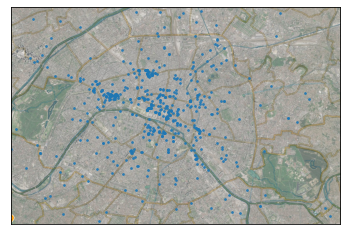

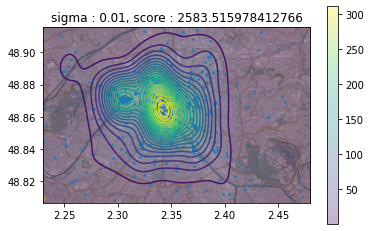

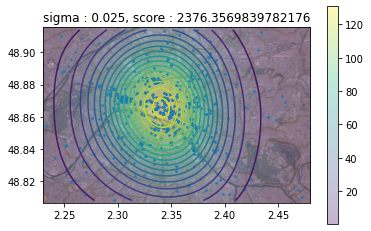

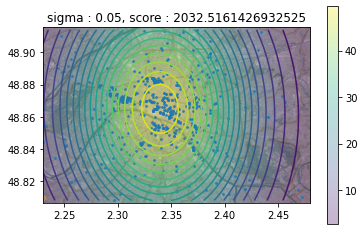

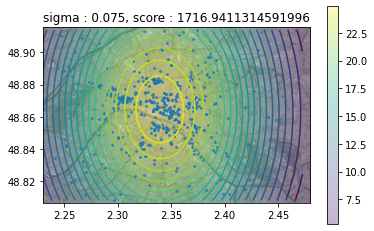

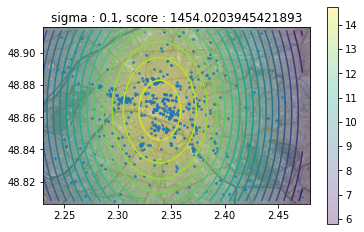

In [121]:
geo_mat, notes = load_poi("night_club")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
plt.xticks([])
plt.yticks([])

for sigma in [0.01, 0.025, 0.05, 0.075, 0.1]:
    nc_kernelDensity = KernelDensity(kernel=kernel_gaussian, sigma=sigma)
    nc_kernelDensity.fit(geo_mat)
    show_density(nc_kernelDensity, geo_mat)
    plt.gca().set_title(f'sigma : {sigma}, score : {nc_kernelDensity.score(geo_mat)}')

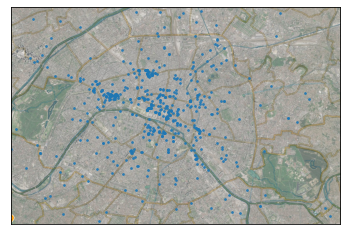

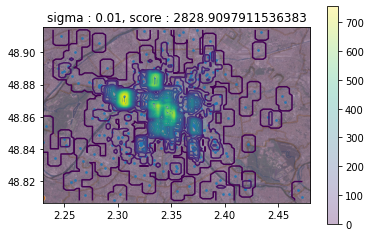

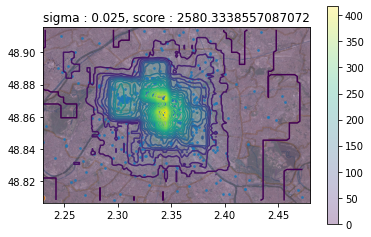

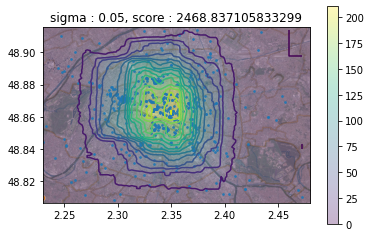

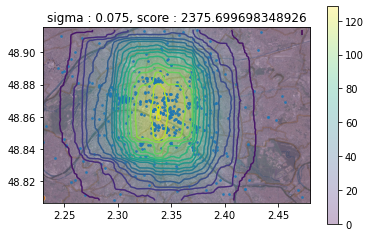

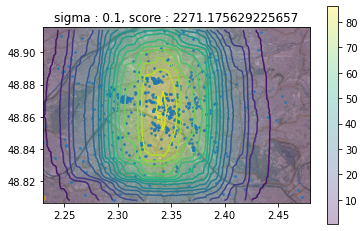

In [122]:
geo_mat, notes = load_poi("night_club")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
plt.xticks([])
plt.yticks([])

for sigma in [0.01, 0.025, 0.05, 0.075, 0.1]:
    nc_kernelDensity = KernelDensity(kernel=kernel_uniform, sigma=sigma)
    nc_kernelDensity.fit(geo_mat)
    show_density(nc_kernelDensity, geo_mat)
    plt.gca().set_title(f'sigma : {sigma}, score : {nc_kernelDensity.score(geo_mat)}')